In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

# 1. Visualize and preprocess the data
## A) Load data and understand composition

In [2]:
from utils import load_subject

# Load data
subject = load_subject()
n_subjects = 27
subjects_list = []
for subject_number in range(1, n_subjects+1):
    subjects_list.append(load_subject(subject_number))
subjects_list[0]

{'number': 1,
 'emg_rectified': array([[0.0684, 0.0024, 0.0024, ..., 0.0488, 0.0024, 0.0342],
        [0.0586, 0.0024, 0.0024, ..., 0.0415, 0.0024, 0.0293],
        [0.0562, 0.0024, 0.0024, ..., 0.0391, 0.0024, 0.0244],
        ...,
        [0.0024, 0.0024, 0.0024, ..., 0.0342, 0.0024, 0.0073],
        [0.0024, 0.0024, 0.0024, ..., 0.0366, 0.0024, 0.0073],
        [0.0024, 0.0024, 0.0024, ..., 0.0391, 0.0024, 0.0024]]),
 'stimulus': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'repetition': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8)}

## B) Exploration of the data
There are measures at 100686 time points from 10 channels (probably 10 electrodes). See below that there are 12 types of movement performed and they are repeated 10 times. The number of samples for each trial is different because of the nature of each exercise.
The data is partially preprocessed

In [3]:
subjects_list[0].keys()

dict_keys(['number', 'emg_rectified', 'stimulus', 'repetition'])

In [4]:
from utils import get_attributes, explore_data

n_stimuli,n_channels, n_repetitions = explore_data(subjects_list[0])

How many types of movement are there? 12
How many repetitions are there? 10
There are 10 channels.
Length of trials: 


Channel                                                               
             1      2      3      4      5      6      7      8      9      10
Stimuli                                                                       
1         305.0  354.0  346.0  371.0  438.0  372.0  430.0  412.0  435.0  352.0
2         193.0  388.0  233.0  234.0  244.0  252.0  316.0  227.0  229.0  302.0
3         524.0  390.0  481.0  433.0  460.0  515.0  199.0  360.0  424.0  356.0
4         348.0  296.0  287.0  276.0  281.0  242.0  278.0  315.0  330.0  329.0
5         452.0  453.0  382.0  416.0  376.0  418.0  430.0  339.0  318.0  368.0
6         293.0  305.0  432.0  286.0  301.0  306.0  254.0  299.0  253.0  329.0
7         246.0  240.0  266.0  263.0  252.0  187.0  259.0  325.0  299.0  278.0
8         211.0  294.0  277.0  359.0  333.0  372.0  374.0  287.0  306.0  185.0
9         197.0  250.0  234.0  222.0  295.0  281.0  269.0  330.0  289.0  241.0
10        458.0  184.0  184.0  270.0  407.0  188.0  338.0  379.0  473.0  306.0
11        186.0  285.0  305.0  195.0  230.0  240.0  222.0  318.0  238.0  272.0
12        341.0  429.0  189.0  239.0  526.0  261.0  185.0  521.0  224.0  319.0

**Observations:**
All the trials did not last the same time, and can not be put together in a tensor:

## C) Visualize and preprocess

### Window and envelope
Now, let's smooth and visualize the data accross the channels. In this example, we will illustrate using data from a single trial (repetition 1 of stimulus 1) using moving average for detecting the envelope.
If plot emg_windows[0][0]: will see 1rst trial and 1rst repetition

In [5]:
from utils import smooth_data

for subject in subjects_list:
    subject = smooth_data(subject, n_stimuli, n_repetitions)

subjects_list[0].keys()

dict_keys(['number', 'emg_rectified', 'stimulus', 'repetition', 'emg_windows', 'emg_envelopes'])

## Visualize the data

Text(0.5, 0.98, 'Envelopes of the EMG signal')

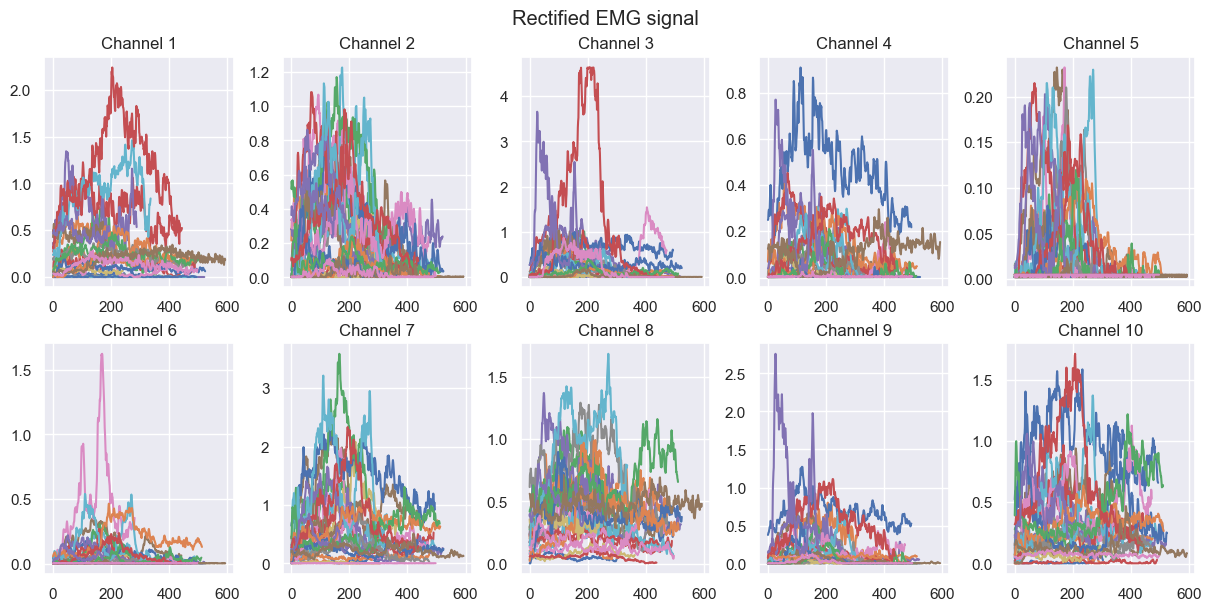

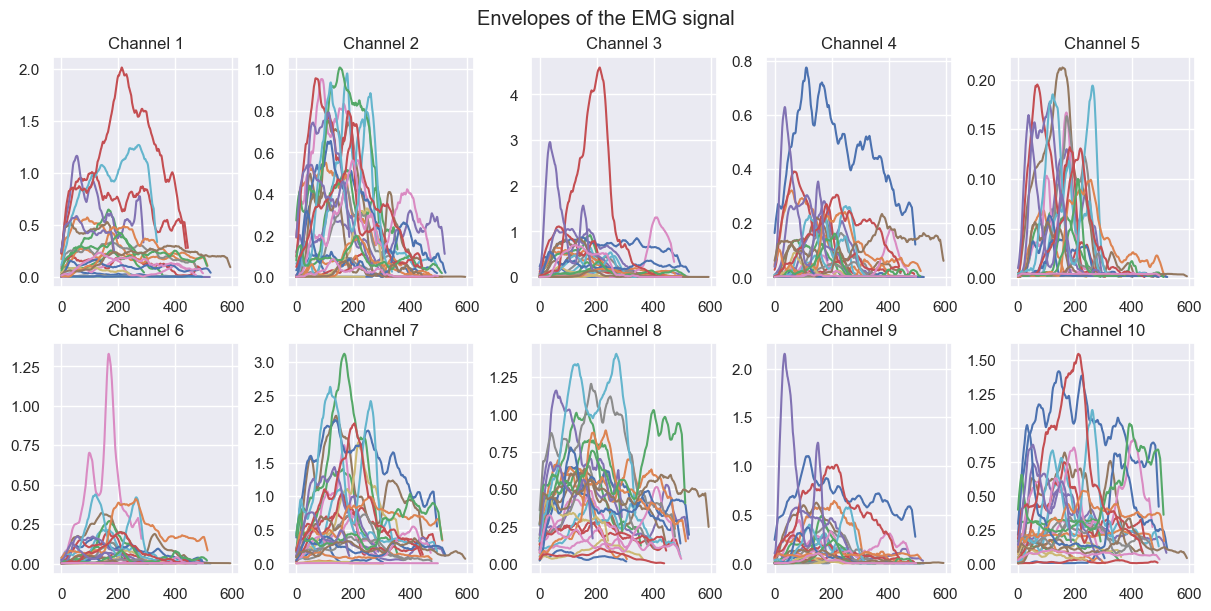

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

# Plot Rectified EMG signal
for channel_idx in range(n_channels): 
    for subject in subjects_list:
        emg_windows = subject['emg_windows']
        ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# Plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(n_channels): 
    for subject in subjects_list:    
        emg_envelopes = subject['emg_envelopes']
        ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")
#plt.legend([subject['number'] for subject in subjects_list])

Text(0.5, 0.98, 'Envelopes of the EMG signal')

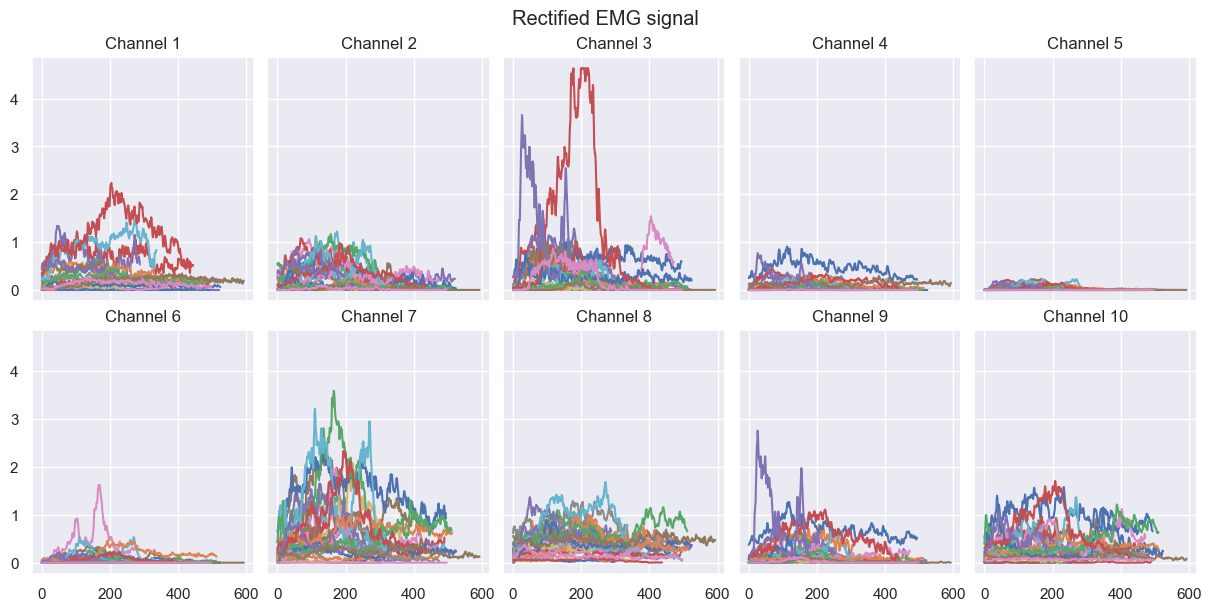

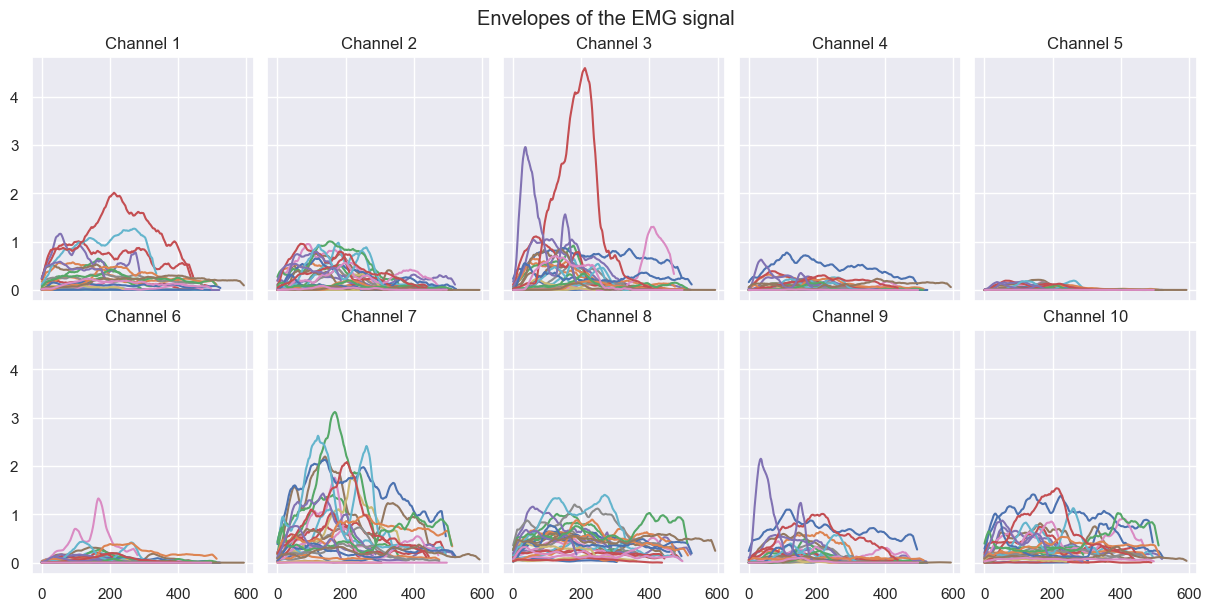

In [7]:
# Now we plot all the channels on the same y-scale for a better comparison
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()


# Plot rectified EMG signal
for channel_idx in range(n_channels): 
    for subject in subjects_list:
        emg_windows = subject['emg_windows']
        ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# Plot envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels): 
    for subject in subjects_list:
        emg_envelopes = subject['emg_envelopes']
        ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")


### Visualizing across repetitions

Remember that we were only looking at a single trial in the previous section. 

To check for the robustness of the signal, we will generally need to repeat the stimulus multiple times and look at the trend of the signal quality over time.

In [8]:
for subject in subjects_list:
    emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            #mean across time for each channel
            emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 
    subject['emg_average_activations'] = emg_average_activations

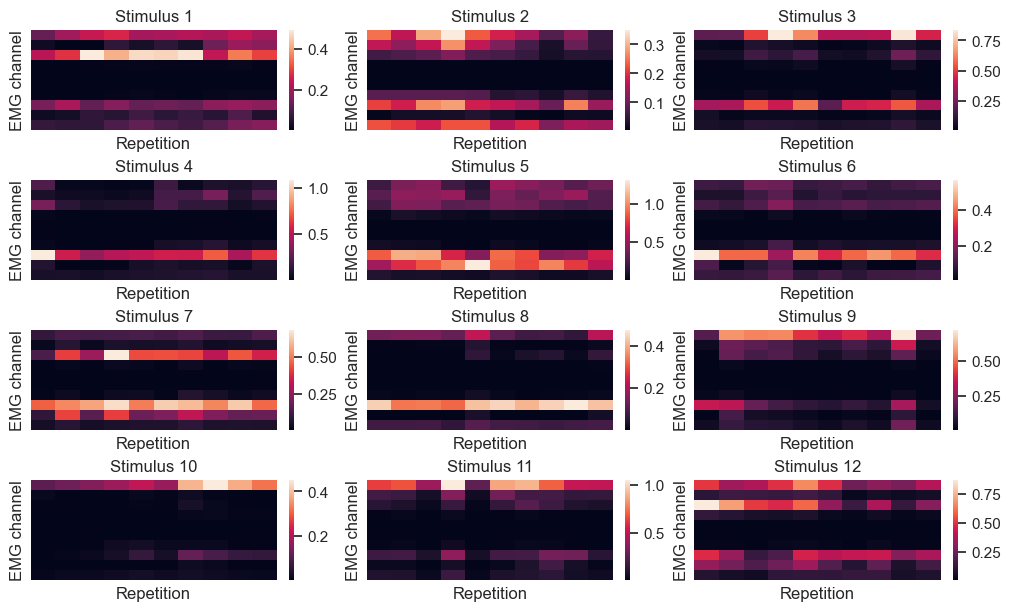

In [9]:
# Visualisation for one subject
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
emg_average_activations = subject['emg_average_activations']
for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

1) The rows capture each channel per stimulus. There is a high homogeneity. Each channel is exposed to the same exercise so they record similar muscle acitivity across repetitions. That's good. 

2) There is some variation in amplitude across repetitions which is normal because it is never done in the exact same manner. 

3) Different stimulus seem to activate different muscles. If we normalize the signals it could make them more comparabel across stimuli

In [10]:
# TODO: Data cleaning!

# 2. Extract features for classification

In [11]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# # Slope sign changes (SSC)
# It counts the number of times the slope changes direction.
ssc = lambda x: np.sum(
    (np.diff(np.sign(np.diff(x, axis=0)), axis=0) != 0).astype(int),
    axis=0
)

# Feel free to add more features


### What do you see? Are the values similar between repetitions and between channels? Explain the possible reasons for similarity/discrepancies.
See that the features are similar across repetitions but with variablity and different across channels. Muscles being activated differently or similarly/electrode impedance... 

/!\ channels 5,6,7 always seem to have very low values so might not be very interesting msucles or electrodes. 

In [12]:
from utils import build_dataset_from_ninapro

In [13]:
def analyze_feature(feature_to_plot, subject_number=0):
    # Create the dataset
    emg_rectified, stimulus, repetition = get_attributes(subjects_list[subject_number])
    dataset, labels = build_dataset_from_ninapro(
        emg=emg_rectified,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav] #, std] #, maxav, rms, wl, ssc]
    )

    # Print dataset dimensions
    print(f"Dataset dimension: {dataset.shape}")
    print(f"Labels dimension: {labels.shape}")

    features_set =dataset.reshape(n_stimuli, n_repetitions, 10)
    fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    for stimuli_idx in range(n_stimuli):
        sns.heatmap(features_set[stimuli_idx, :, :].T, ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
        ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
        ax[stimuli_idx].set_xlabel("Repetition")
        ax[stimuli_idx].set_ylabel("EMG channel")

Dataset dimension: (120, 10)
Labels dimension: (120,)


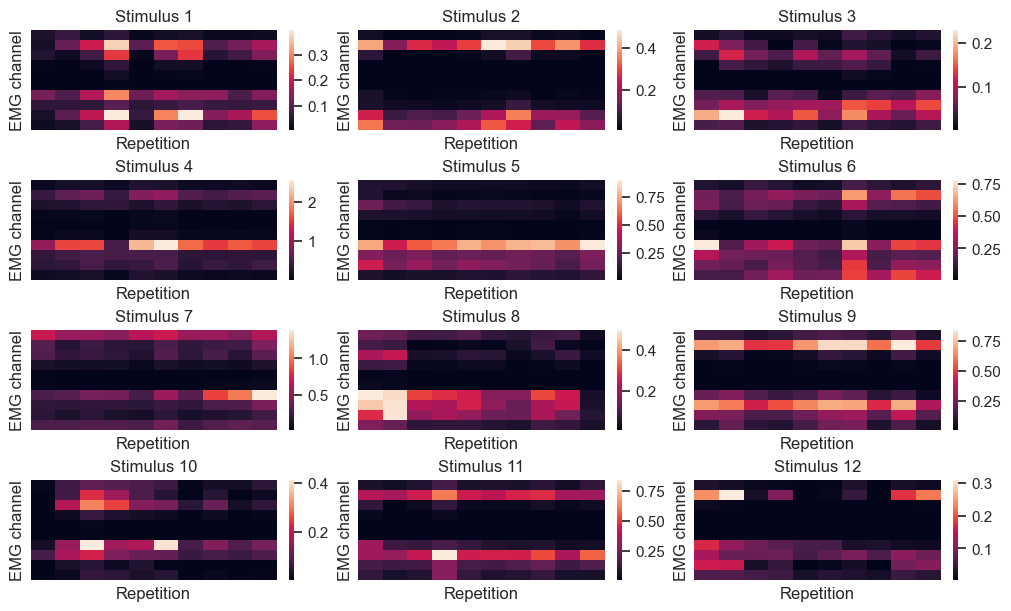

In [14]:
analyze_feature(mav)

Dataset dimension: (120, 10)
Labels dimension: (120,)


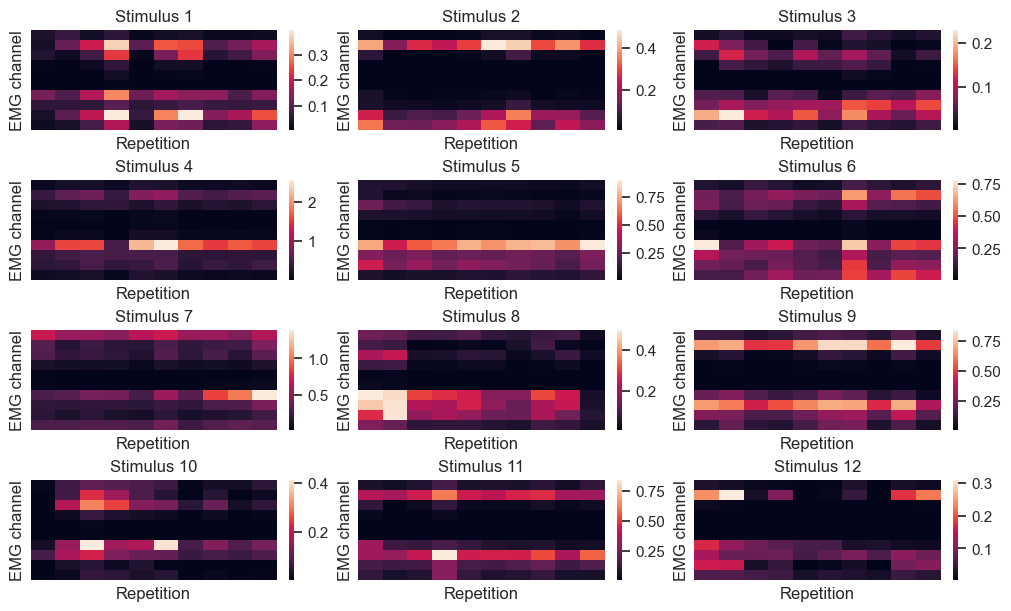

In [15]:
analyze_feature(std)

Dataset dimension: (120, 10)
Labels dimension: (120,)


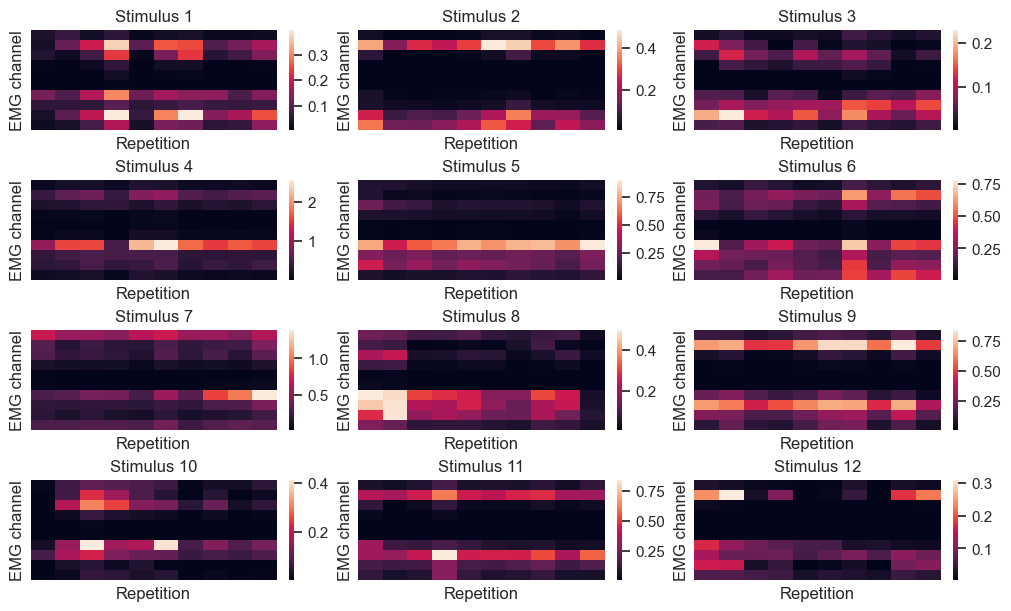

In [16]:
analyze_feature(maxav)

Dataset dimension: (120, 10)
Labels dimension: (120,)


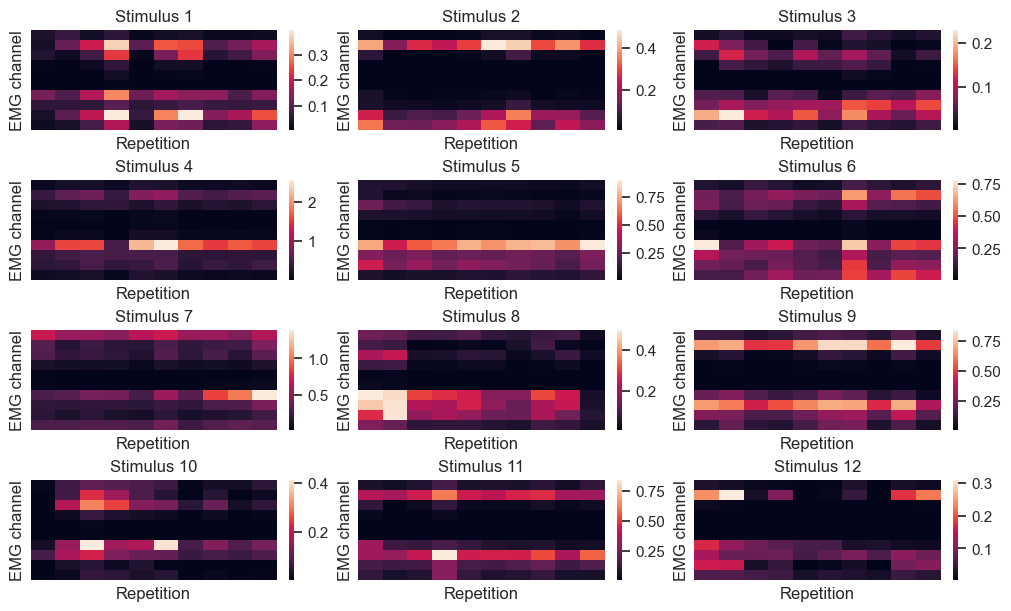

In [17]:
analyze_feature(rms)

Dataset dimension: (120, 10)
Labels dimension: (120,)


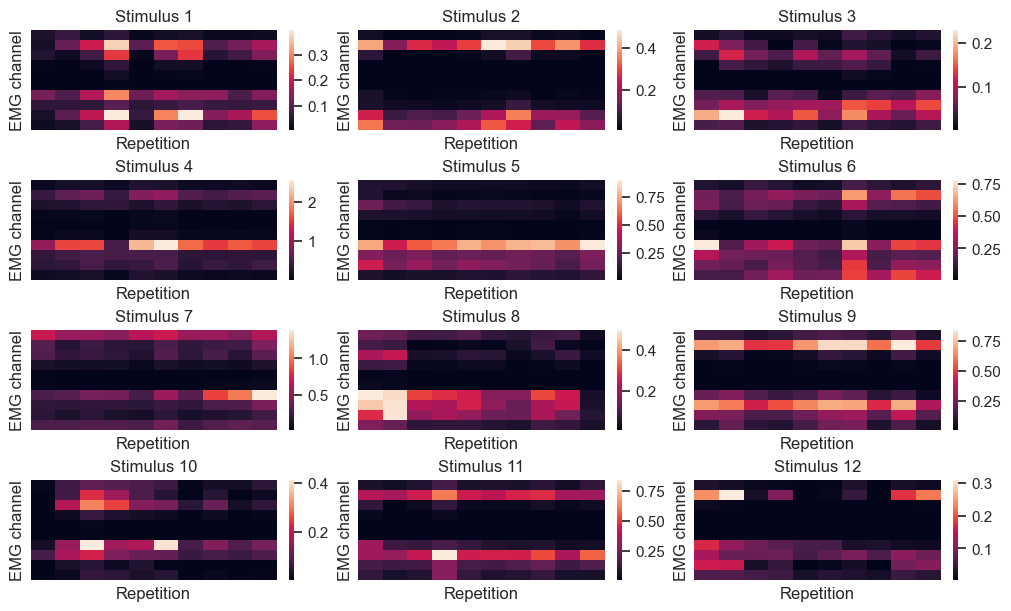

In [18]:
analyze_feature(wl)

# 4. Classifier SVM
## A) Split the data into train and test sets
## B) Train the classifier

In [19]:
datasets_list = []
labels_list = []
for subject in subjects_list:
    emg, stimulus, repetition = get_attributes(subjects_list[0])
    dataset_, labels_ = build_dataset_from_ninapro(emg, stimulus, repetition, features=[mav, std, maxav, rms, wl, ssc])
    datasets_list.append(dataset_)
    labels_list.append(labels_)

dataset = np.concatenate(datasets_list)
labels = np.concatenate(labels_list)

dataset.shape

(3240, 60)

Accuracy score: 1.0


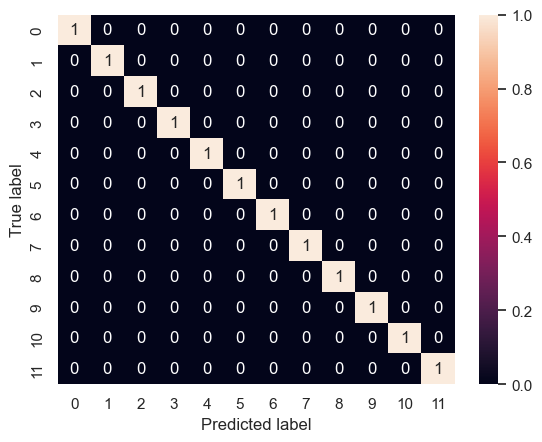

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import Support Vector Classifier (SVM)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and testing sets
# Here, 30% of the data is reserved for testing, and 70% is used for training
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=34)

# Normalizing the data bc SVM uses distance metric so it is very sensitive to scale. 
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# We are using Support Vector Machine (SVM) 
clf = SVC(kernel='linear')  #linear seems to work best
clf.fit(X_train_z, y_train)  

# Evaluate the classifier on the test set
y_pred = clf.predict(X_test_z)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()


### Cross-validation

In [21]:
from sklearn.model_selection import cross_val_score
X_scaled = scaler.fit_transform(dataset)  # Scale the entire dataset

# Initialize the SVM classifier
clf = SVC(kernel='linear')  # Use a linear kernel, or you can try 'rbf', 'poly', etc.

# Perform cross-validation
# Here, we use 5-fold cross-validation (cv=5)
scores = cross_val_score(clf, X_scaled, labels, cv=5)  # The classifier, data, labels, and number of splits

# Print the accuracy scores for each fold
print(f"Accuracy scores of all models: {scores}")

# Print the mean accuracy across all folds
print(f"Mean accuracy across all models: {np.mean(scores)}")


Accuracy scores of all models: [1. 1. 1. 1. 1.]
Mean accuracy across all models: 1.0


### Hyperparameter optimization

In [22]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for the SVC model
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ['linear', 'rbf', 'poly'],  # Types of kernels to try
    "gamma": ['scale', 'auto', 0.01, 0.1, 1]  # Kernel coefficient
}

# Initialize the SVC model
svc = SVC()

# Set up GridSearchCV for hyperparameter tuning
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')  # 5-fold cross-validation

# Fit the model using the training data
grid.fit(X_train_z, y_train)  # Use the scaled training data

# Print the best estimator and the best hyperparameters found by the grid search
print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

# Predict the labels for the test data using the best model
y_pred = grid.predict(X_test_z)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}")


Best estimator: SVC(C=0.1, kernel='linear')
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy score of best model: 1.0


# 6. Feature selection and dimension reduction

In [23]:
X_train_z.shape

(2268, 60)

Estimated mutual information between each feature and the target:
 [2.49 2.49 2.49 2.46 2.46 2.43 2.49 2.49 2.49 2.49 2.49 2.49 2.49 2.46
 2.46 2.42 2.49 2.49 2.49 2.49 2.16 2.39 2.32 1.99 1.36 1.34 2.37 2.39
 2.37 2.29 2.49 2.49 2.49 2.46 2.46 2.43 2.49 2.49 2.49 2.49 2.47 2.49
 2.49 2.35 2.27 2.09 2.49 2.49 2.48 2.49 2.05 1.79 2.11 2.01 1.89 1.84
 1.97 2.05 1.98 2.04]

Accuracy score of a model with k best features: 0.9382716049382716


Text(0.5, 20.049999999999997, 'Predicted label')

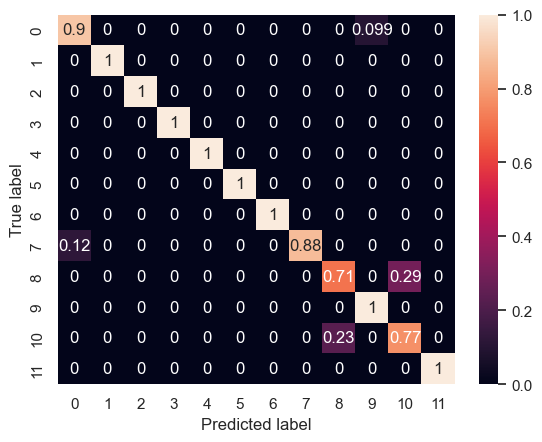

In [24]:
# Import necessary functions for feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Calculate mutual information between each feature and the target variable.
# Mutual information is a measure of the dependency between variables.
# A higher value indicates a stronger relationship.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {np.round(mutual_info,2)}\n")

# Select the 10 features with highest MI
k_best = SelectKBest(mutual_info_classif, k=10)
k_best.fit(X_train_z, y_train)

# Transform the training and testing sets to only include the selected features
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

clf =  SVC(**grid.best_params_) ## TODO: is this still a linear kernel?
clf.fit(X_train_best, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf.predict(X_test_best)

# Calculate the accuracy of the model with the selected features.
# Accuracy is the ratio of correctly predicted instances to the total instances.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with k best features: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification model.
# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

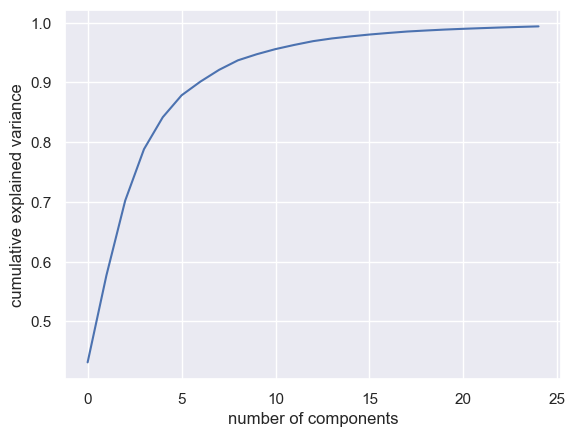

In [25]:
# Feature selection and dimension reduction with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=25)
pca.fit(X_train_z)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Accuracy score of a model with k best features: 1.0


Text(0.5, 20.049999999999997, 'Predicted label')

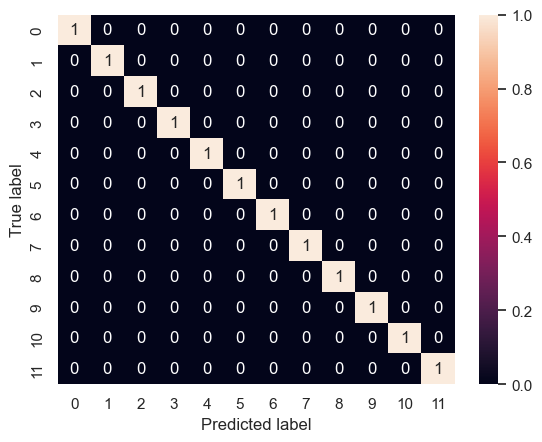

In [26]:
n_chosen_components = 15

pca = PCA(n_components=n_chosen_components)
pca.fit(X_train_z)

X_train_pca = pca.transform(X_train_z)
X_test_pca = pca.transform(X_test_z)

clf =  SVC(**grid.best_params_) ## TODO: is this still a linear kernel?
clf.fit(X_train_pca, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf.predict(X_test_pca)

# Calculate the accuracy of the model with the selected features.
# Accuracy is the ratio of correctly predicted instances to the total instances.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with k best features: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification model.
# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

In [27]:
np.unique(y_pred, return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([81, 81, 81, 82, 76, 80, 90, 82, 78, 83, 83, 75], dtype=int64))

In [28]:
np.unique(y_test, return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([81, 81, 81, 82, 76, 80, 90, 82, 78, 83, 83, 75], dtype=int64))

# PART 2 END : 

### 3. Train a classification model 

Accuracy score: 0.5442386831275721


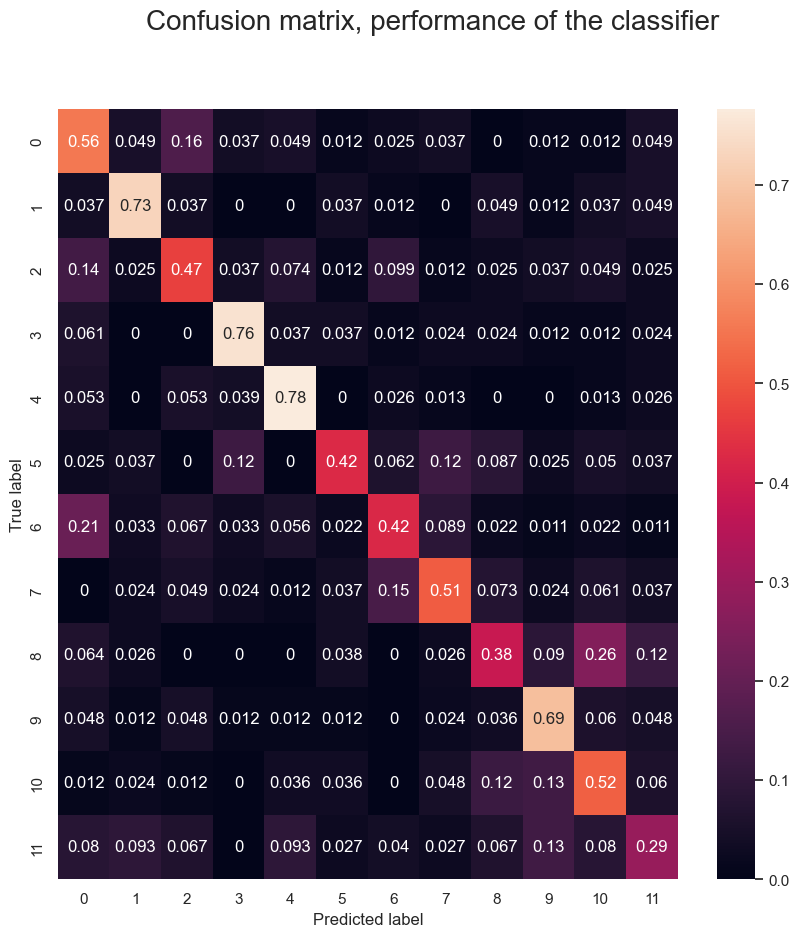

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=34)

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  
X_test_z = scaler.transform(X_test)        

clf = SVC(kernel='linear')  #linear seems to work best
clf.fit(X_train_z, y_train)  

y_pred = clf.predict(X_test_z)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix 
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots(figsize  =(10, 10))
fig.suptitle('Confusion matrix, performance of the multisubject classifier', size = 20)
sns.heatmap(confmat, annot=True, ax=ax)  
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

### 4. cross-validation 1 vs other: see how well the model generalize to new subject

KeyError: ''

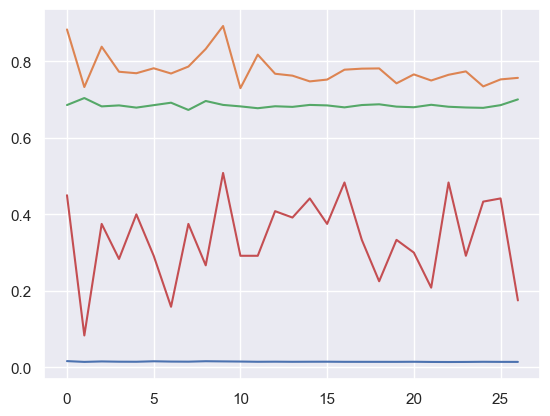

In [ ]:
from sklearn.model_selection import cross_validate

X_scaled = scaler.fit_transform(dataset)  # Scale the entire dataset
# Initialize the SVM classifier
clf = SVC(kernel='linear')  # Use a linear kernel, or you can try 'rbf', 'poly', etc.

# Perform cross-validation
results = cross_validate(clf, X_scaled, labels, cv=n_subjects, return_train_score = True)

Testing accuracy scores of all models: [0.45       0.08333333 0.375      0.28333333 0.4        0.29166667
 0.15833333 0.375      0.26666667 0.50833333 0.29166667 0.29166667
 0.40833333 0.39166667 0.44166667 0.375      0.48333333 0.33333333
 0.225      0.33333333 0.3        0.20833333 0.48333333 0.29166667
 0.43333333 0.44166667 0.175     ]
Mean testing accuracy across all models: 0.3370370370370371


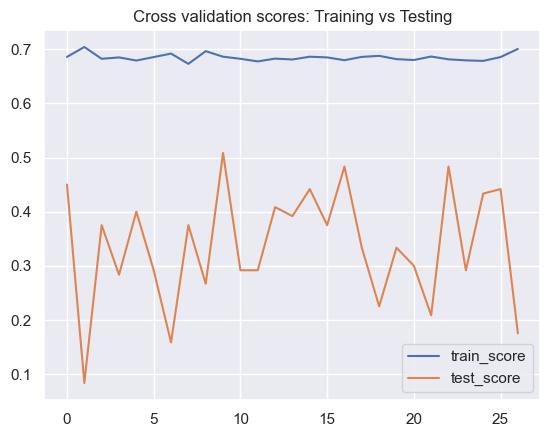

In [ ]:
plt.plot( results['train_score'], label = 'train_score')
plt.plot(results['test_score'], label = 'test_score')
plt.legend()
plt.title("Cross validation scores: Training vs Testing")

# Print the accuracy scores for each fold
print(f"Testing accuracy scores of all models: {results['test_score']}")

# Print the mean accuracy across all folds
print(f"Mean testing accuracy across all models: {np.mean(results['test_score'])}")


### 5. Cross validation by varying the number of subject in test vs train

In [ ]:
ACCU = []
SIZE =[]
for i in range(n_subjects - 1) : 
    train_test_size = i +1

    X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=(i+1)/n_subjects, shuffle=False, random_state=34)

    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)  
    X_test_z = scaler.transform(X_test)        

    clf = SVC(kernel='linear')  #linear seems to work best
    clf.fit(X_train_z, y_train)  

    y_pred = clf.predict(X_test_z)

    accuracy = accuracy_score(y_test, y_pred)
    ACCU.append(accuracy)
    SIZE.append(train_test_size)
    print(f"Accuracy score for split test_size = {i+1} subject, {np.round((i+1)/n_subjects, 2)} % of the dataset : {accuracy}")

Accuracy score for split test_size = 1 subject, 0.04 % of the dataset : 0.175
Accuracy score for split test_size = 2 subject, 0.07 % of the dataset : 0.25416666666666665
Accuracy score for split test_size = 3 subject, 0.11 % of the dataset : 0.28055555555555556
Accuracy score for split test_size = 4 subject, 0.15 % of the dataset : 0.2833333333333333
Accuracy score for split test_size = 5 subject, 0.19 % of the dataset : 0.32166666666666666
Accuracy score for split test_size = 6 subject, 0.22 % of the dataset : 0.3013888888888889
Accuracy score for split test_size = 7 subject, 0.26 % of the dataset : 0.319047619047619
Accuracy score for split test_size = 8 subject, 0.3 % of the dataset : 0.309375
Accuracy score for split test_size = 9 subject, 0.33 % of the dataset : 0.2777777777777778
Accuracy score for split test_size = 10 subject, 0.37 % of the dataset : 0.295
Accuracy score for split test_size = 11 subject, 0.41 % of the dataset : 0.31136363636363634
Accuracy score for split test_s

Text(0.5, 1.0, 'Accuracy of the multisubject SMV classfier')

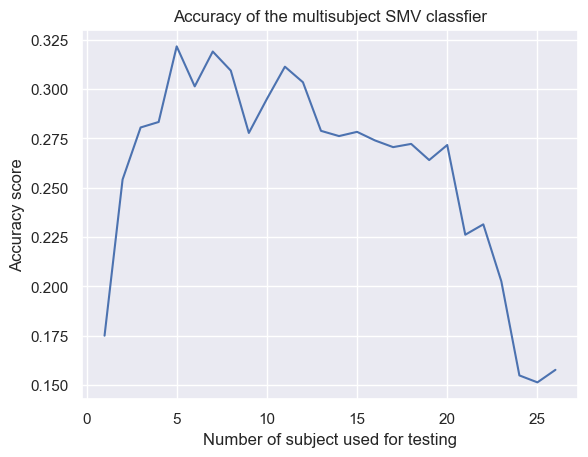

In [ ]:
plt.plot(SIZE, ACCU)
plt.xlabel('Number of subject used for testing')
plt.ylabel('Accuracy score')
plt.title('Accuracy of the multisubject SMV classfier')